In [1]:
import cmocean.cm as cm
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
# import statfieldodels.api as sm
import xarray as xr
from salishsea_tools import viz_tools

In [44]:
cmap = cm.rain #'pink_r'#cm.rain #cm.ice_r #'ocean_r' #'pink_r'

In [3]:
foramt = "{:.3}"
myformat = {'bias': foramt, 'rmse': foramt, 'crmse':foramt, 'swillmott': foramt, 'slopedev': foramt, 'const': foramt,
                         'systematic': foramt, 'nonsystematic':foramt, 
                    'spread': foramt}

def use_f_2(x):
    return "%.2f" % x

In [57]:
def bias(df, obs, mod):
    diffy = df[mod] - df[obs]
    return diffy.count(), diffy.mean()

def rmse(df, obs, mod):
    return (np.sqrt(((df[mod] - df[obs])**2).mean()))

def crmse(rmse, bias):
    return (np.sqrt(rmse**2 - bias**2))

def swillmott(df, obs, mod):
    meanobs = df[obs].mean()
    return (((df[mod] - df[obs])**2).sum()
            /(( (df[mod] - meanobs).abs() + (df[obs] - meanobs).abs() )**2).sum())
    
def slope_inter(df, obs, mod):
    X = df[obs]
    y = df[mod]
    X = sm.add_constant(X)

    # Fit and make the predictions by the model
    model = sm.OLS(y, X, missing='drop').fit()
#    print (model.summary())
    predictions = model.predict(X)
    
    nonsyst = np.sqrt(((y - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obs])**2).mean())
    return model.params[obs], model.params['const'], systematic, nonsyst

def wolfram_perp(df, obsin, modin):
    
    mod = np.array(df[modin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    obs = np.array(df[obsin][(df[modin] == df[modin]) & (df[obsin] == df[obsin])])
    
    n = mod.shape[0]

    y2s = (mod**2).sum()
    ys = mod.sum()
    x2s = (obs**2).sum()
    xs = obs.sum()
    xys = (mod * obs).sum()
    B = 0.5 * ( (y2s - ys**2/n) - (x2s - xs**2/n)) / (xs * ys/n - xys)
    b1 = -B + np.sqrt(B*B + 1)
    a1 = (ys - b1*xs)/n
    predictions = a1 + b1 * df[obsin]
    
    nonsyst = np.sqrt(((df[modin] - predictions)**2).mean())
    systematic = np.sqrt(((predictions - df[obsin])**2).mean())
  
    return a1, b1, systematic, nonsyst

def spread(df, obs, mod):
    return 1 - ((df[mod] - df[mod].mean())**2).mean() / ((df[obs] - df[obs].mean())**2).mean() 

def read_pieces(pieces):
    temp1 = pd.read_csv(pieces[0])
    for piece in pieces[1:]:
        nextpiece = pd.read_csv(piece)
        if 'ferry' in piece:
            nextpiece['k'] = 0
        temp1 = pd.concat([temp1, nextpiece], ignore_index=True)
#    temp1['SA'] = temp1.SA.fillna(value=temp1['salinity (g/kg)'])
    return temp1

def filter_bad_data(temp1):
# bad data in Puget Sound (pugts)
    temp1_nohook = temp1[(temp1.Lat > 47.30) | (temp1.Lon < -122.5) | (temp1.Z < 5) | (temp1.SA > 26) ]
# bad onc data
 #   temp1_nobox_nohook = temp1_nohook[(temp1_nohook['depth (m)'] != 107) | (temp1_nohook.SA > 29)]
# bad ferry data
  #  temp1_clean = temp1_nobox_nohook[((temp1_nobox_nohook.SA > 0.2) | (temp1_nobox_nohook.mod_vosaline - temp1_nobox_nohook.SA < 20)) 
  #                                   & ((temp1_nobox_nohook.Lon > -123.8) | (temp1_nobox_nohook.SA > 14))]
    return temp1_nohook

def plot_and_stats(temp1, name, idepth, jdepth, fig, ax, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    print (temp1[temp1.k <= idepth])
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
    
    counts, xedges, yedges, color = ax.hist2d(select[one], 
                                              select[two], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
    fig.colorbar(color, ax=ax)
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
#    m, c, syst, nonsyst = slope_inter(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    ax.plot([vmin, vmax], [vmin, vmax], 'k-');
    xr = np.arange(vmin, vmax, 0.5)
#    ax.plot(xr, c + m * xr, 'r-');
    ax.plot(xr, a1 + b1 * xr, 'r-')
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh
    # ax.arrow(sc+vmin, bot+vmin, 0, sh-np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(sc+vmin, top+vmin, 0, -sh+np.abs(tbias)/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, bot+vmin, 0, sh-syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(2*sc+vmin, top+vmin, 0, -sh+syst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, bot+vmin, 0, sh-nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True)
    # ax.arrow(3*sc+vmin, top+vmin, 0, -sh+nonsyst/2, head_width=0.5*sc, head_length=0.2*sc, length_includes_head=True);
    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}
    # ax.text(0.8*sc+vmin, 0.9*bot*shift_text+vmin, 'bias', rotation=90)
    # ax.text(1.8*sc+vmin, 0.72*bot*shift_text+vmin-shift_text, 'systematic', rotation=90)
    # ax.text(2.8*sc+vmin, 0.6*bot*shift_text+vmin-shift_text, 'non-systematic', rotation=90)
    
    ax.set_title(f'{name}, {field} {whichdepths}{string}');
    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2, counts

def highlight_max_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''

    is_max = abs(s) == abs(s).max()
    is_min = abs(s) == abs(s).min()
    color = []
    for v, v2 in zip(is_max, is_min):
        if v:
            color.append('red')
        elif v2:
            color.append('darkgreen')
        else:
            color.append('black')
    return ['color: %s' % color[i] for i in range(len(is_max))]

def plot_allyears(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    startyear = min(years)# years_psf[0], years_pug[0]), years_onc[0])
    endyear = max(years) #years_psf[-1], years_pug[-1]), years_onc[-1])
    fig.suptitle(f'Year {startyear}-{endyear}')
    print (idepth, jdepth)
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d202111, counts1 = plot_and_stats(filter_bad_data(temp1), '202111', idepth, jdepth, fig, axs[0], whichdepths, reverse, string)

    alltogether = d202111
    
    fig.savefig(f'{whichdepths}_{field}{string}_201905_202111_for_allyears.png')
    
    # f = open(f'./{whichdepths}_{field}{string}_201905_202111_for_allyears_table.tex', 'w')
    # f.write(alltogether.to_latex(column_format='lcccccccccc', 
    #         formatters=[None, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2, use_f_2]))
    # f.close()
    return alltogether, counts1

def get_combined(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    
    # f.close()
    return temp1

def get_stats(temp1, name, idepth, jdepth, whichdepths, reverse, string, boxes=False, box=None, boxname=None):
    if boxes: # boxes for sebregion box
        corn = box
        select = temp1[(temp1.k >= idepth) & (temp1.k <= jdepth) &
                              (temp1.j >= corn[0]) & (temp1.j <= corn[1]) &
                              (temp1.i >= corn[2]) & (temp1.i <= corn[3])]
        shift_text = 0.94
    else:
        select = temp1[(temp1.k >= idepth) & (temp1.k < jdepth)]
        shift_text = 1
    
    print (swillmott(select, 'SA', 'mod_vosaline'))
    
    if reverse:
        one = modn
        two = obsn
    else:
        one = obsn
        two = modn
   
   #calculate stats
    number, tbias = bias(select, one, two)
    trmse = rmse(select, one, two)
    tcrmse = crmse(trmse, tbias)
    tswillmott = swillmott(select, one, two)
    a1, b1, syst, nonsyst = wolfram_perp(select, one, two)
    tspread = spread(select, one, two)
    xr = np.arange(vmin, vmax, 0.5)
    sc = scale/12
    sh = 2*sc-1
    bot = scale
    top = bot + 2*sh

    Cp2 = {'number': number,
            'bias': tbias,
          'rmse': trmse,
           'crmse': tcrmse,
          'swillmott': tswillmott,
          'slopedev': 1-b1,
          'const': a1,
          'systematic': syst,
          'nonsystematic': nonsyst,
          'spread': tspread}

    dCp2 = pd.DataFrame(data=Cp2, index=[name])
    return dCp2

def get_combined(years, years_psf, years_pug, years_onc, years_ferry, idepth, jdepth, whichdepths, reverse=False):
    if reverse:
        string = '_reverse'
    else:
        string = ''
        
    pieces1 = []
    for year in years:
        pieces1.append(
              f'/ocean/cstang/MOAD/analysis-camryn/notebooks/model_evals/ObsModel/ObsModel_202111_CIOOS_{year}0101_{year}1231.csv')
    # for year in years_psf:
    #     pieces1.append(
    #         f'//data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_psfts_{year}0101_{year}1231.csv')
    # for year in years_pug:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    #      #   f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_pugts_{year}0101_{year}1231.csv')
    # for year in years_onc:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_onc_{year}0101_{year}1231.csv')
    # for year in years_ferry:
    #     pieces1.append(
    #         f'/data/sallen/results/MEOPAR/202111/ObsModel/ObsModel_201905R_ferry_{year}0101_{year}1231.csv')
    temp1 = read_pieces(pieces1)
    d202111 = get_stats(filter_bad_data(temp1),field , idepth, jdepth, whichdepths, reverse, string)
    
    return temp1,d202111

In [58]:
field = 'Salinity'
obsn = 'SA'
modn = 'mod_vosaline'
vmax = 34
vmin = 0
dbin = 0.5
scale = 24

idepth = 0
jdepth = 39

sal_data,d_sal = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')

d_sal.style.format(myformat).apply(highlight_max_min)

0.030881198010775227


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1788,-0.273,0.681,0.624,0.0309,-0.0912,-3.07,0.322,0.629,-0.183


### Temperature

In [59]:
field = 'Temperature'
obsn = 'consT'
modn = 'mod_votemper'
vmax = 25
vmin = 0
dbin = 0.5
scale = 24

0.030881198010775227


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Salinity,1788,-0.273,0.681,0.624,0.0309,-0.0912,-3.07,0.322,0.629,-0.183


,number,bias,rmse,crmse,swillmott,slopedev,const,systematic,nonsystematic,spread
Temperature,1788,-0.107,0.446,0.433,0.0206,-0.0919,-0.983,0.174,0.43,-0.212


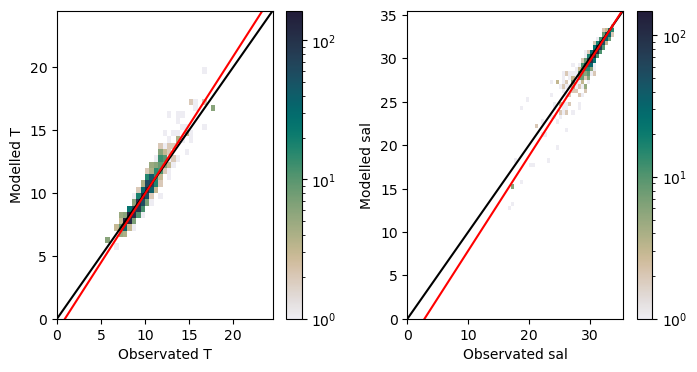

In [60]:
idepth = 0
jdepth = 39

temp_data,d_temp = get_combined([2017,2018,2019,2020,2021,2022]
                                          , []#[2015, 2016, 2017]
                                          , []#[2015, 2016, 2017, 2018]
                                       , []#[2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                       , []#[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
                                          , idepth, jdepth, 'alldepths')


fig,[ax,ax2] = plt.subplots(1,2,figsize=(8,4))
counts, xedges, yedges, color = ax.hist2d(temp_data['sea_water_temperature'],temp_data['mod_votemper'], 
                                           bins=np.arange(vmin, vmax, dbin), norm=LogNorm(), cmap=cmap);
ax.set_xlabel('Observated T')
ax.set_ylabel('Modelled T')
fig.colorbar(color, ax=ax)
ax.plot(np.arange(0,vmax,0.5),np.arange(0,vmax,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(temp_data,obsn,modn)
line = a1+np.arange(vmin, vmax, 0.5)*b1
ax.plot(np.arange(vmin, vmax, 0.5),line,'r')

counts, xedges, yedges, color = ax2.hist2d(sal_data['SA'],sal_data['mod_vosaline'], 
                                           bins=np.arange(0, 36, 0.5), norm=LogNorm(), cmap=cmap);
ax2.set_xlabel('Observated sal')
ax2.set_ylabel('Modelled sal')
fig.colorbar(color, ax=ax2)
ax2.plot(np.arange(0,36,0.5),np.arange(0,36,0.5),color='k')
a1,b1,stm,nstm = wolfram_perp(sal_data,'SA','mod_vosaline')
line = a1+np.arange(0, 36, 0.5)*b1
ax2.plot(np.arange(0, 36, 0.5),line,'r')

fig.subplots_adjust(wspace=0.3)

display(d_sal.style.format(myformat).apply(highlight_max_min))
d_temp.style.format(myformat).apply(highlight_max_min)
